In [56]:
#!/usr/bin/env python
from utils.file_operations import input_parse
from utils.simulation_helper import set_mesh_geometry
from utils.analysis.make_movies import write_movies_two_component_2d
import os
import argparse
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils import plot
import cv2
import seaborn as sns
from scipy.spatial import Delaunay, ConvexHull
from scipy.ndimage import uniform_filter1d
import scipy.interpolate as interp



class simDir:
    def __init__(self,
                 directory: str,
                 movie_parameters: str = "movie_parameters.txt"):
        self.directory = directory

        # Parse simulation parameter input. Simulation directories have this file by
        # default.
        self.params_file: str = os.path.join(self.directory, "input_params.txt")
        self.params = input_parse(self.params_file)

        # Simulation directories have this file by default.
        self.hdf5_file: str =  os.path.join(self.directory, "spatial_variables.hdf5")

        # Parse movie parameter input.
        self.movie_params_file = movie_parameters
        if os.path.isfile(self.movie_params_file):
            self.movie_params = input_parse(self.movie_params_file)
        else:
            print("Using default movie parameters.")
            self.movie_params = {'num_components': 2.0,
                                 'color_map': ['Blues', 'Reds'],
                                 'titles': ['Protein', 'RNA'],
                                 'figure_size': [15, 6]}

    def run(self, geo: bool=True, hdf5: bool=True,
            plot_limits: bool=True, condensate: bool=True):
        if geo:
            # Load Gmsh geometry
            self.geometry = set_mesh_geometry(self.params)
        if hdf5:
            # Load concentration profile
            with h5py.File(self.hdf5_file, mode="r") as concentration_dynamics:
                # Read concentration profile data from files
                self.concentration_profile = []
                for i in range(int(self.movie_params['num_components'])):
                    conc_arr = concentration_dynamics[f'c_{i}'][:]
                    conc_arr = conc_arr[~np.all(conc_arr == 0, axis=1)]
                    self.concentration_profile.append(conc_arr)
        if plot_limits:
            self.getPlotLimits()

    def makeSubdirectory(self, subdirectory: str):
        # Make a directory within the simulation directory
        subdir_path = os.path.join(self.directory, subdirectory)
        try:
            os.mkdir(subdir_path)
            print("Successfully made the directory " + subdir_path + " ...")
        except OSError:
            print(subdir_path + " directory already exists")
        return subdir_path

    def getPlotLimits(self):
        # Get upper and lower limits of the concentration values from the concentration profile data
        self.plotting_range = []
        conc = self.concentration_profile
        for i in range(int(self.movie_params['num_components'])):
            # Check if plotting range is explicitly specified in movie_parameters
            if 'c{index}_range'.format(index=i) in self.movie_params.keys():
                self.plotting_range.append(self.movie_params['c{index}_range'.format(index=i)])
            else:
                min_value = conc[i].min()
                max_value = conc[i].max()
                self.plotting_range.append([min_value, max_value])

    def makeMovie(self):
        write_movies_two_component_2d(self.directory,
                                      self.hdf5_file,
                                      self.movie_params,
                                      self.geometry.mesh)
    def makeFigure(self,
                   i:int,
                   n_rows:int=4,
                   n_cols:int=4):
        n_frames = n_rows*n_cols
        subdir_path = self.makeSubdirectory("figures")
        frames = np.linspace(0, self.concentration_profile[0].shape[0]-1, num=n_frames, dtype=int)
        fig = plt.figure(figsize=(6*(n_rows),6*(n_cols)))
        gs = fig.add_gridspec(n_rows,n_cols)
        axes = [fig.add_subplot(gs[i,j]) for i in range(n_cols) for j in range(n_rows)]
        for t, frame in enumerate(frames):
            # Generate and save plots
            # axes = axes.flatten()
            cs = axes[t].tricontourf(self.geometry.mesh.x, self.geometry.mesh.y, self.concentration_profile[i][frame],
                                levels=np.linspace(int(self.plotting_range[i][0]*100)*0.01,
                                                    int(self.plotting_range[i][1]*100)*0.01,
                                                    256),
                                cmap=self.movie_params['color_map'][i])
            border = plt.Circle((0,0), self.params["radius"],
                                color='tab:gray', fill=False, linewidth=2)
            axes[t].add_patch(border)
            axes[t].autoscale_view()
            axes[t].xaxis.set_tick_params(labelbottom=False, bottom=False)
            axes[t].yaxis.set_tick_params(labelleft=False, left=False)
            axes[t].set_aspect('equal', 'box')
            plt.setp(axes[t].spines.values(), visible=False)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        cbar = fig.colorbar(cs,
                            ax=axes,
                            ticks=np.linspace(int(self.plotting_range[i][0]*100)*0.01,
                                            int(self.plotting_range[i][1]*100)*0.01,
                                            3),
                            shrink=0.6
                            )
        cbar.ax.tick_params(labelsize=30)
        fig.suptitle(self.movie_params['titles'][i], fontsize=40)
        fig.savefig(fname=subdir_path + \
            '/{}.png'.format(self.movie_params['titles'][i]),
                    dpi=300, format='png')
        return fig

    def condensate(self,
                   i:int=0):
        self.threshold = self.params["c_bar_1"]
        conc = self.concentration_profile[i].copy()
        self.mask = conc>self.threshold
        conc[~self.mask]=0
        pos = np.array([self.geometry.mesh.x,self.geometry.mesh.y])
        self.com = (conc @ pos.T)/np.tile(conc.sum(axis=1),(2,1)).T

    def sort_boundary_points(points):
        hull = ConvexHull(points)
        hull_path = hull.vertices
        sorted_boundary = points[hull_path, :]
        return sorted_boundary

    def resample_path(points, num_points=None, closed_loop=True):
        # Calculate the cumulative distance along the path
        distance = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
        distance = np.insert(distance, 0, 0)  # Insert a 0 at the beginning

        # The number of points we want to resample to
        if not num_points:
            num_points = len(points)

        # Create an interpolation function based on the distances and the points
        interp_func = interp.interp1d(distance, points, kind='linear', axis=0)

        # Create an array of evenly spaced distance values
        new_distances = np.linspace(0, distance[-1], num_points)

        # Use the interpolation function to get new points at these distances
        new_points = interp_func(new_distances)

        if closed_loop:
            # Ensure the path is closed by connecting the last point to the first
            new_points = np.vstack((new_points, new_points[0]))

        return new_points

In [57]:
root = "/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/20231017_flow/20231022_output/M1_1.0_beta_-0.25_gamma_-0.1_kappa_0.05_kprod_0.1_c1Init_3.6_noiseVar_0.0_rxnSigma_2.5_seed_5.5_loc_10"
sim = simDir(root)

In [58]:
sim.run()

In [59]:
sim.condensate()

<Axes: >

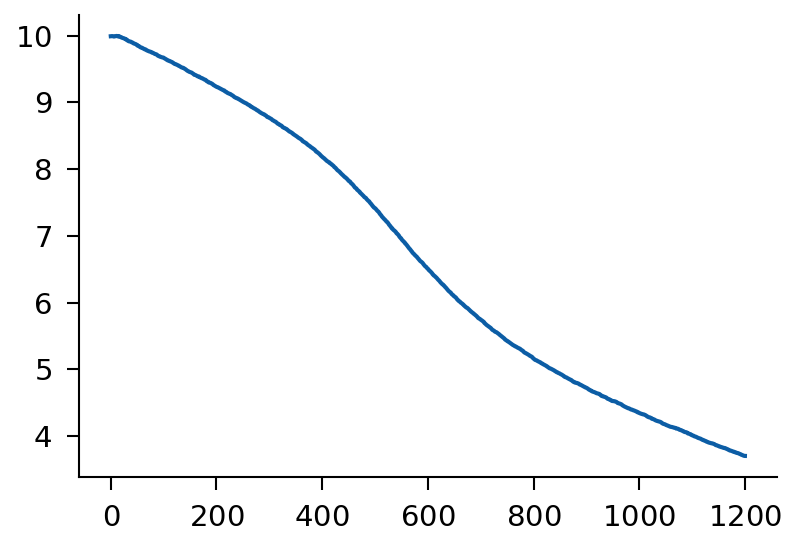

In [60]:
sns.lineplot(sim.com[:,0])

<Axes: >

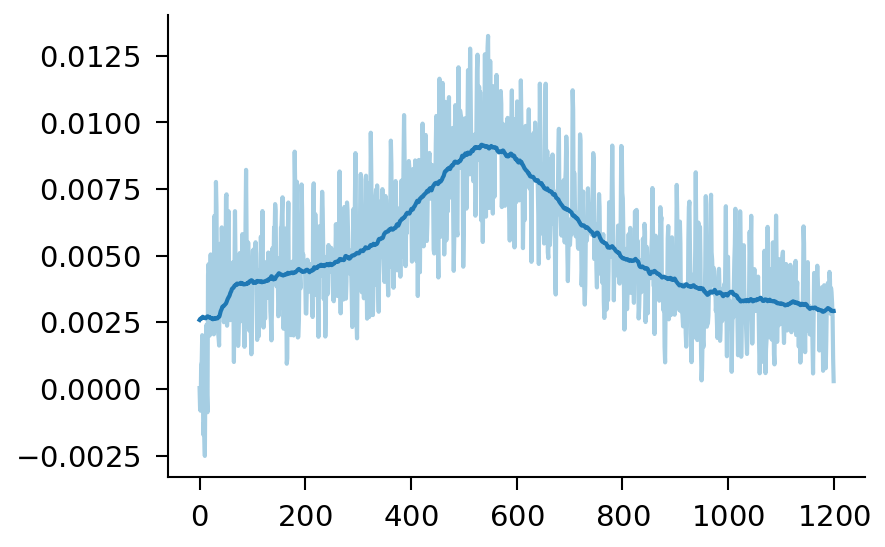

In [6]:
arr = -np.gradient(com[:,0])
c = sns.color_palette("Paired")
sns.lineplot(arr, color=c[0])
sns.lineplot(uniform_filter1d(arr,100), color=c[1])

In [8]:
# tri = Delaunay(points)
# edges = set()
# indicies = set()
# for simplex in tri.simplices:
#     for i in range(3):
#         # Edge is represented by a tuple of point indices sorted in ascending order
#         edge = tuple(sorted([simplex[i], simplex[(i+1)%3]]))
#         if edge in edges:
#             edges.remove(edge)  # If the edge is already in the set, it's not a boundary
#         else:
#             edges.add(edge)  # Otherwise, add the edge as a potential boundary

# # Extract the unique vertices that form the boundary edges
# for edge in edges:
#     indicies.add(edge[0])
#     indicies.add(edge[1])

# boundary_points = points[list(indicies)]

In [9]:
edge_lst = []
points = np.vstack((sim.geometry.mesh.x, sim.geometry.mesh.y)).T
for n in range(len(mask)):
    condensate_shadow = points[mask[n]]
    arr = resample_path(sort_boundary_points(condensate_shadow),1000)
    edge_lst.append(arr)
edge_arr = np.array(edge_lst)
xydist = edge_arr.max(axis=1)-edge_arr.min(axis=1)
ratio = xydist[:,0]/xydist[:,1]
e = np.sqrt(np.where(ratio<1,1-ratio**2,1-1/ratio**2))

<Axes: >

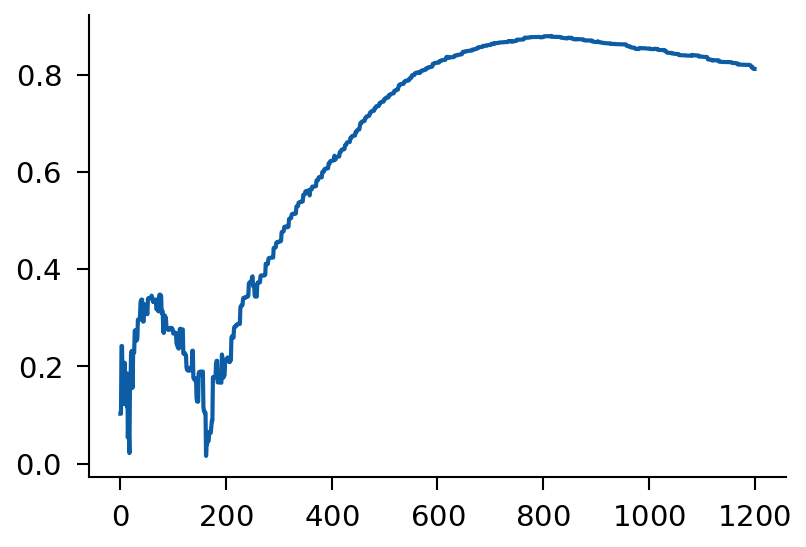

In [12]:
sns.lineplot(e)

In [13]:
r = np.sqrt(((np.array(edge_lst)-com[:,None,:])**2).sum(axis=2))
var_r = np.var(r,axis=1)

<Axes: >

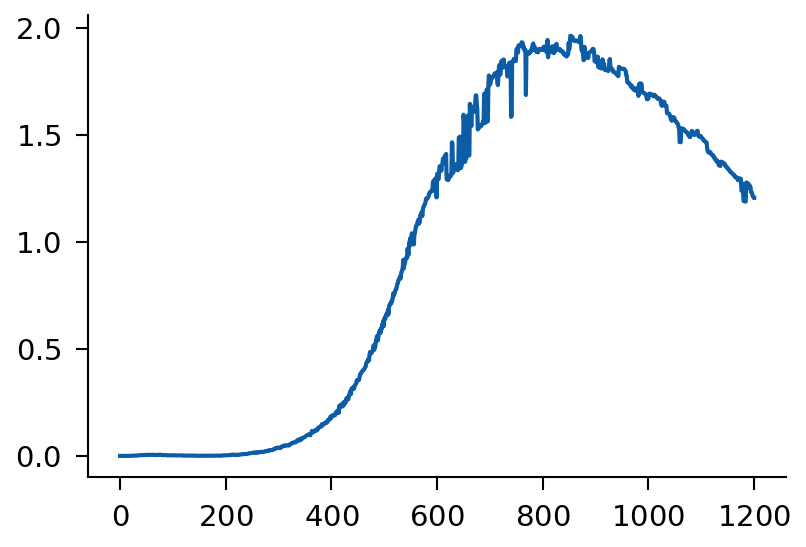

In [14]:
sns.lineplot(var_r)

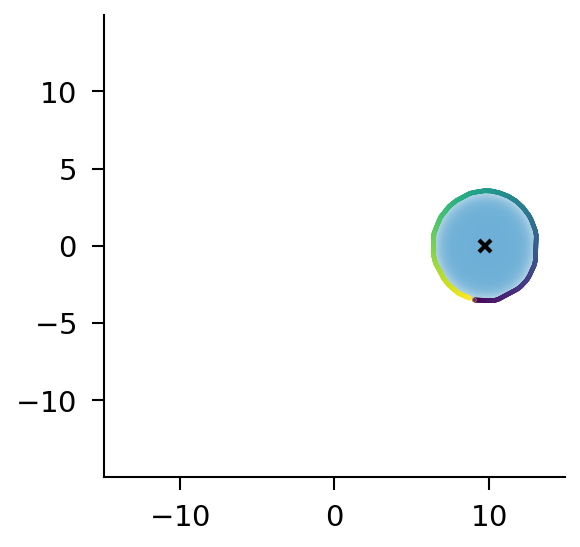

In [15]:
n = 75
fig, ax = plt.subplots()
ax.tricontourf(sim.geometry.mesh.x, sim.geometry.mesh.y, conc[n],
            levels=np.linspace(int(sim.plotting_range[0][0]*100)*0.01,
                               int(sim.plotting_range[0][1]*100)*0.01,
                                                    256),
            cmap=sim.movie_params['color_map'][0])
ax.plot(com[n][0], com[n][1], "xk")
ax.set_aspect('equal', 'box')
arr = resample_path(sort_boundary_points(points[mask[n]]),1000)
x = arr[:,0]
y = arr[:,1]
ax.scatter(x,y,c=np.arange(len(x)), s=0.01)